# problem discription 
Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the
news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting
to see how that impacted the stock prices of the company and whether Time series models
or any other predictive models can do justice to such situations. This dataset has monthly
stock prices of the bank since its inception and includes closing, starting, highest, and lowest
stock prices of every month. The main objective is to predict the stock’s closing price of the
month.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Almabetter/data_YesBank_StockPrices.csv')
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [ ]:
import datetime
from time import strptime
from datetime import datetime

In [ ]:
date_df=df['Date'].str.split("-", n = 1, expand = True)
date_df[0] = date_df[0].apply(lambda x: strptime(x,'%b').tm_mon)
date_df['year'] = date_df[1].apply(lambda x: int(x)+2000)
date_df["period"] = date_df['year'].astype(str) + date_df[0].astype(str)
date_df["period"]= date_df[['year', 0]].astype(str).agg('-'.join, axis=1)
date_df['Date_new_format'] =  date_df['period'].apply(lambda x: datetime.strptime(x,'%Y-%m'))
date_df.Date_new_format= pd.to_datetime(date_df.period)
date_df['month']=date_df[0]
date_df.head()

,0,1,year,period,Date_new_format,month
0,7,05,2005,2005-7,2005-07-01,7
1,8,05,2005,2005-8,2005-08-01,8
2,9,05,2005,2005-9,2005-09-01,9
3,10,05,2005,2005-10,2005-10-01,10
4,11,05,2005,2005-11,2005-11-01,11


In [ ]:
df.index = date_df['Date_new_format']
date_df.index=date_df['Date_new_format']
X=df.copy()
Y=df['Close']

In [ ]:
X.drop(['Date','Close'],axis=1,inplace=True)
X['month']=date_df['month']
X['year']=date_df['year']
X.head()

,Open,High,Low,month,year
Date_new_format,,,,,
2005-07-01,13.00,14.00,11.25,7,2005
2005-08-01,12.58,14.88,12.55,8,2005
2005-09-01,13.48,14.87,12.27,9,2005
2005-10-01,13.20,14.47,12.40,10,2005
2005-11-01,13.35,13.88,12.88,11,2005


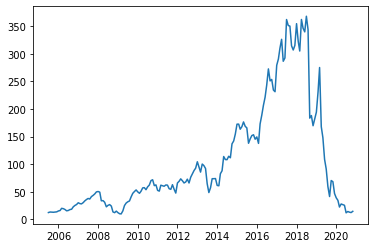

In [ ]:
plt.plot(Y)

In [ ]:
size = int(len(X.values) * 0.8)
X_train=X[:size]
X_test=X[size:]
Y_train=Y[:size]
Y_test=Y[size:]

In [ ]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [ ]:
 from sklearn.preprocessing import StandardScaler
 scaler=StandardScaler()
 scaler.fit(X)
 X_train=scaler.transform(X_train)
 X_test=scaler.transform(X_test)

In [ ]:
lrmodel=LR()
svrmodel=SVR()
lrmodel.fit(X_train,Y_train)
svrmodel.fit(X_train,Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

10.608732187763588

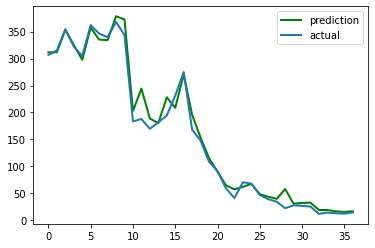

In [ ]:
lrpred=lrmodel.predict(X_test)
plt.plot(lrpred, "g", label="prediction", linewidth=2.0)
plt.plot(Y_test.values, label="actual", linewidth=2.0)
plt.legend()
mean_absolute_error(Y_test,lrpred)

113.44306081858502

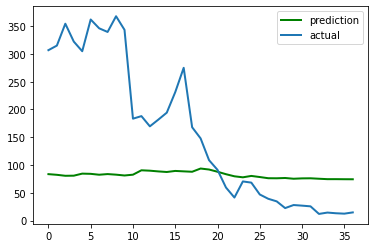

In [ ]:
svrpred=svrmodel.predict(X_test)
plt.plot(svrpred, "g", label="prediction", linewidth=2.0)
plt.plot(Y_test.values, label="actual", linewidth=2.0)
plt.legend()
mean_absolute_error(Y_test,svrpred)


10.60820239188858

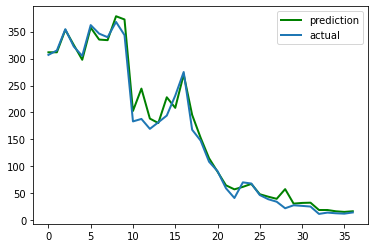

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, Y_train)
rdpred=ridge.predict(X_test)
plt.plot(rdpred, "g", label="prediction", linewidth=2.0)
plt.plot(Y_test.values, label="actual", linewidth=2.0)
plt.legend()
mean_absolute_error(Y_test,rdpred)

11.775977815447146

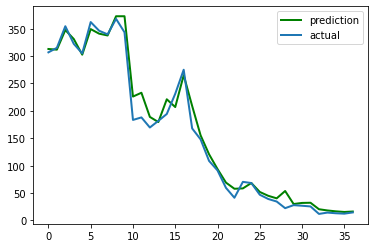

In [ ]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, Y_train)
lassopred=lasso.predict(X_test)
plt.plot(lassopred, "g", label="prediction", linewidth=2.0)
plt.plot(Y_test.values, label="actual", linewidth=2.0)
plt.legend()
mean_absolute_error(Y_test,lassopred)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
model = XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, Y_train, Y_test, model, 
                                 param_grid, cv=tscv)
print(model.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  1.1min


[11:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8}


[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  2.1min finished


20.63062632380305

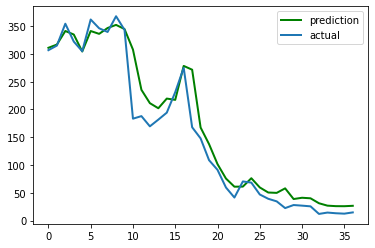

In [ ]:
xgb = model.best_estimator_
xgpred= xgb.predict(X_test)
plt.plot(xgpred, "g", label="prediction", linewidth=2.0)
plt.plot(Y_test.values, label="actual", linewidth=2.0)
plt.legend()
mean_absolute_error(Y_test,xgpred)